# Inlet Analysis
Looking at how many inlets influence each node

In [1]:
import sys
sys.path.append('../')
from src.util import *
import numpy as np 
import snap
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt

### Load in the networks
Sanity check number of nodes and edges

In [87]:
G_LS174t = snap.LoadEdgeList(snap.PNEANet, "../data/Edgelist_v2/LS174T_clean_EdgesList.txt", 0, 1)
G_SW1222 = snap.LoadEdgeList(snap.PNEANet, "../data/Edgelist_v2//SW1222_clean_EdgesList.txt", 0, 1)
G_Healthy = snap.LoadEdgeList(snap.PNEANet, "../data/Edgelist_v2//Mesentery_clean_EdgeList.txt", 0, 1)

print "Healthy Network - Number of nodes: {}, Number of Edges {}".format(G_Healthy.GetNodes(), G_Healthy.GetEdges())
print "LS174T Tumour - Number of nodes: {}, Number of Edges {}".format(G_LS174t.GetNodes(), G_LS174t.GetEdges())
print "SW1222 Tumour - Number of nodes: {}, Number of Edges {}".format(G_SW1222.GetNodes(), G_SW1222.GetEdges())

Healthy Network - Number of nodes: 388, Number of Edges 545
LS174T Tumour - Number of nodes: 16354, Number of Edges 20377
SW1222 Tumour - Number of nodes: 64239, Number of Edges 77450


In [31]:
def generateInletCounts(G):
    inlets = getInletIds(G)
    inletDict = collections.defaultdict(list)
    nodeIds = [node.GetId() for node in G.Nodes()]
    inletCounts = collections.defaultdict(int)
    for inlet in tqdm(inlets):
        outSet = snap.GetBfsTree(G, inlet, True, False)
        for node in outSet.Nodes():
            inletCounts[node.GetId()] += 1
            inletDict[node.GetId()].append(inlet)
    return (inletCounts, inletDict)

In [32]:
inletCounts, _ = generateInletCounts(G_LS174t)
sortedCounts_LS = sorted(inletCounts.values())
xvals_LS = range(len(sortedCounts_LS))

100%|██████████| 1751/1751 [00:01<00:00, 1535.83it/s]


In [5]:
inletCounts, _ = generateInletCounts(G_SW1222)
sortedCounts_SW = sorted(inletCounts.values())
xvals_SW = range(len(sortedCounts_SW))

100%|██████████| 10209/10209 [00:05<00:00, 1939.12it/s]


In [91]:
print "Avg Inlet Counts LS174t: ", float(sum(sortedCounts_LS))/len(sortedCounts_LS)
print "Avg Inlet Counts SW1222: ", float(sum(sortedCounts_SW))/len(sortedCounts_SW)

Avg Inlet Counts LS174t:  9.85141249847
Avg Inlet Counts SW1222:  9.52314014851


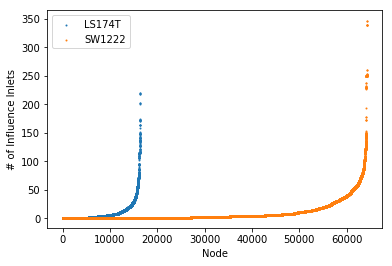

In [33]:
plt.scatter(xvals_LS, sortedCounts_LS, s=1, label='LS174T')
plt.scatter(xvals_SW, sortedCounts_SW, s=1, label='SW1222')
plt.xlabel('Node')
plt.ylabel('# of Influence Inlets')
plt.legend()

### Plot cumulative distribution that is normalised

In [73]:
inlets_LS = getInletIds(G_LS174t)
x = collections.Counter(sortedCounts_LS)
x_normalised_LS = [float(y)/len(inlets_LS) for y in x.keys()]
y_normalised_LS = [float(y)/G_LS174t.GetNodes() for y in x.values()]

print min(x_normalised_LS), max(x_normalised_LS)
print min(y_normalised_LS), max(y_normalised_LS)

0.000571102227299 0.125071387778
6.11471199706e-05 0.344747462395


In [74]:
inlets_SW = getInletIds(G_SW1222)
x = collections.Counter(sortedCounts_SW)
x_normalised_SW = [float(y)/len(inlets_SW) for y in x.keys()]
y_normalised_SW = [float(y)/G_SW1222.GetNodes() for y in x.values()]

print min(x_normalised_SW), max(x_normalised_SW)
print min(y_normalised_SW), max(y_normalised_SW)

9.79527867568e-05 0.0339896170046
1.55668674793e-05 0.422873955074


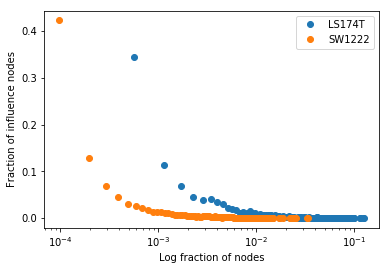

In [78]:
plt.plot(x_normalised_LS, y_normalised_LS,'o',label="LS174T")
plt.plot(x_normalised_SW, y_normalised_SW,'o', label="SW1222")
plt.xscale('log')
# plt.yscale('log')
plt.xlabel("Log fraction of nodes")
plt.ylabel("Fraction of influence nodes")
plt.legend()

## Node removal analysis

In [29]:
def rankInlets(G):
    inlets = getInletIds(G)
    outList = []
    for inlet in inlets:
        outList.append((inlet, snap.GetBfsTree(G, inlet, True, False).GetNodes()))
    return sorted(outList, key=lambda args: args[1], reverse=True)

In [46]:
def decrementInletCount(G, inlet, inletCountOg):
    inletCounts = copy.deepcopy(inletCountOg)
    nodeIds = [node.GetId() for node in G.Nodes()]
    outSet = snap.GetBfsTree(G, inlet, True, False)
    for node in outSet.Nodes():
        inletCounts[node.GetId()] -= 1
    countZero = sum([1 if val == 0 else 0 for val in inletCounts.values()])
    return countZero, inletCounts

In [49]:
def inletKillAttack(G):
    inletRanks = rankInlets(G)
    inletCounts, inletDict = generateInletCounts(G)
    nodesKilled = []
    for x in tqdm(inletRanks): #run in order of highest outset
        curInlet = x[0]
        numNodesRemoved, newCounts = decrementInletCount(G, curInlet, inletCounts)
        nodesKilled.append(numNodesRemoved)
    return nodesKilled

In [61]:
nodeCounts = inletKillAttack(G_LS174t)
totalNodes = [G_LS174t.GetNodes()]
nodesRemaining_LS = []
for count in nodeCounts:
    totalNodes[0] -= count
    nodesRemaining_LS.append(totalNodes[0])

100%|██████████| 1751/1751 [01:52<00:00, 16.26it/s]


In [59]:
nodeCounts = inletKillAttack(G_SW1222)
totalNodes = [G_SW1222.GetNodes()]
nodesRemaining_SW = []
for count in nodeCounts:
    totalNodes[0] -= count
    nodesRemaining_SW.append(totalNodes[0])

100%|██████████| 10209/10209 [42:16<00:00,  4.45it/s]


In [65]:
x_coords_LS = [float(x)/len(normalisedNodesRemaining_LS) 
               for x in range(len(normalisedNodesRemaining_LS))]
normalisedNodesRemaining_LS = [float(x)/G_LS174t.GetNodes() 
                               for x in nodesRemaining_LS]

x_coords_SW = [float(x)/len(normalisedNodesRemaining_SW) 
               for x in range(len(normalisedNodesRemaining_SW))]
normalisedNodesRemaining_SW = [float(x)/G_SW1222.GetNodes() 
                               for x in nodesRemaining_SW]

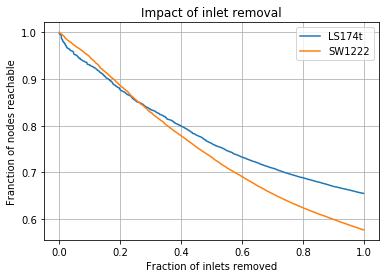

In [68]:
plt.figure()
plt.plot(x_coords_LS, normalisedNodesRemaining_LS, label="LS174t")
plt.plot(x_coords_SW, normalisedNodesRemaining_SW, label="SW1222")
plt.xlabel("Fraction of inlets removed")
plt.ylabel("Franction of nodes reachable")
plt.title("Impact of inlet removal")
plt.grid()
plt.legend()
plt.savefig("../figs/nodeRemoval.pdf")

## Connectivity

In [92]:
def getNodeConnectivityFrac(G, nodeId):
    total = snap.GetBfsTree(G, nodeId, True, False).GetNodes() +\
                snap.GetBfsTree(G, nodeId, False, True).GetNodes()
    return float(total)/G.GetNodes()

def getConnectivityList(G):
    return [getNodeConnectivityFrac(G, node.GetId()) for node in tqdm(G.Nodes())]

In [93]:
LS_connectivity = getConnectivityList(G_LS174t)
SW_connectivity = getConnectivityList(G_SW1222)

16354it [00:07, 2218.90it/s]
64239it [00:51, 1246.25it/s]


In [94]:
LS_conn_log = [np.log(x) for x in LS_connectivity]
SW_conn_log = [np.log(x) for x in SW_connectivity]

In [95]:
min(SW_conn_log), min(LS_conn_log)

(-9.9717534932062168, -8.6036155060538135)

/Users/magdy/Desktop/Stanford/Fall18/224w/nodeEnv/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


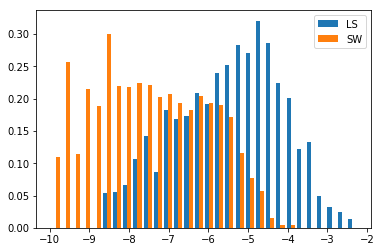

In [96]:
plt.hist([LS_conn_log, SW_conn_log], bins=30, normed=True, label=['LS','SW'])
plt.legend()